## Importações e Carregamento dos Dados

In [1]:
%pip install -q numpy -q scikit-learn -q matplotlib -q seaborn -q shap -q cryptography

Note: you may need to restart the kernel to use updated packages.


Neste bloco, importamos todas as bibliotecas necessárias e carregamos os dados de treino e teste. Também exibimos informações básicas sobre o dataset de treino.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from utils.functions import *
import warnings
from cryptography.fernet import Fernet
import os
import io
warnings.filterwarnings('ignore')

In [67]:
try:
    key = os.getenv('CRYPTO_KEY')
    if not key:
        with open('.env', 'rb') as key_file:
            key = key_file.read()
    
    f = Fernet(key)
    
    with open('data/train.parquet.encrypted', 'rb') as file:
        encrypted_data = file.read()
        decrypted_data = f.decrypt(encrypted_data)
        df = pd.read_parquet(io.BytesIO(decrypted_data))
    
    with open('data/test.parquet.encrypted', 'rb') as file:
        encrypted_data = file.read()
        decrypted_data = f.decrypt(encrypted_data)
        test = pd.read_parquet(io.BytesIO(decrypted_data))
        
except Exception as e:
    print("Erro ao carregar os dados:", e)
    exit()

print("Informações do Dataset:")
print(df.info())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152038 entries, 0 to 152037
Data columns (total 62 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      151333 non-null  float64
 1   x1      152037 non-null  float64
 2   x2      152037 non-null  float64
 3   x3      71762 non-null   float64
 4   x4      152037 non-null  float64
 5   x5      152037 non-null  float64
 6   x6      146648 non-null  float64
 7   x7      152037 non-null  float64
 8   x8      149891 non-null  float64
 9   x9      147583 non-null  float64
 10  x10     151937 non-null  float64
 11  x11     71762 non-null   float64
 12  x12     151333 non-null  float64
 13  x13     151937 non-null  float64
 14  x14     152037 non-null  float64
 15  x15     149943 non-null  float64
 16  x16     71762 non-null   float64
 17  x17     152037 non-null  float64
 18  x18     146412 non-null  float64
 19  x19     151333 non-null  float64
 20  x20     151876 non-null 

## Criação de Amostra e Análise Inicial

Aqui, criamos uma amostra com 10% dos dados de cada classe para análises iniciais. Exibimos a distribuição das classes na amostra e criamos uma matriz de correlação para visualizar as relações entre as variáveis.

In [68]:
df_limpo, tratamentos_aplicados = analisar_e_tratar_nulos(df)

for coluna, info in tratamentos_aplicados.items():
    print(f"Coluna: {coluna}")
    print(f"Método: {info['metodo']}")
    print(f"Valor: {info['valor']}")
    print("---")

# Verificar a eficácia do tratamento
print("Contagem de valores nulos após o tratamento:")
print(df_limpo.isnull().sum())

amostra_tratada = criar_amostra(df_limpo)

Coluna: x0
Shapiro p-valor: 4.771471328502486e-105
Anderson estatística: 2251.9183271498187, valor crítico: 0.787
Coluna: x3
Shapiro p-valor: 1.2777433165265444e-135
Anderson estatística: 5312.138949558881, valor crítico: 0.787
Coluna: x6
Shapiro p-valor: 5.231602716181295e-195
Anderson estatística: 56480.93457321587, valor crítico: 0.787
Coluna: x8
Shapiro p-valor: 1.1029105025609446e-92
Anderson estatística: 1360.6198842308659, valor crítico: 0.787
Coluna: x9
Shapiro p-valor: 4.291330429733026e-99
Anderson estatística: 1891.6376694880018, valor crítico: 0.787
Coluna: x10
Shapiro p-valor: 1.8333672506866006e-158
Anderson estatística: 12151.399938832416, valor crítico: 0.787
Coluna: x11
Shapiro p-valor: 1.026009130875097e-145
Anderson estatística: 6949.383440072212, valor crítico: 0.787
Coluna: x12
Shapiro p-valor: 1.6876620606762434e-165
Anderson estatística: 14022.00634553819, valor crítico: 0.787
Coluna: x13
Shapiro p-valor: 3.5647742825648694e-187
Anderson estatística: 34852.144157


Tamanho da amostra: 15204
Distribuição das classes na amostra:
y
1    0.856222
0    0.143778
Name: proportion, dtype: float64


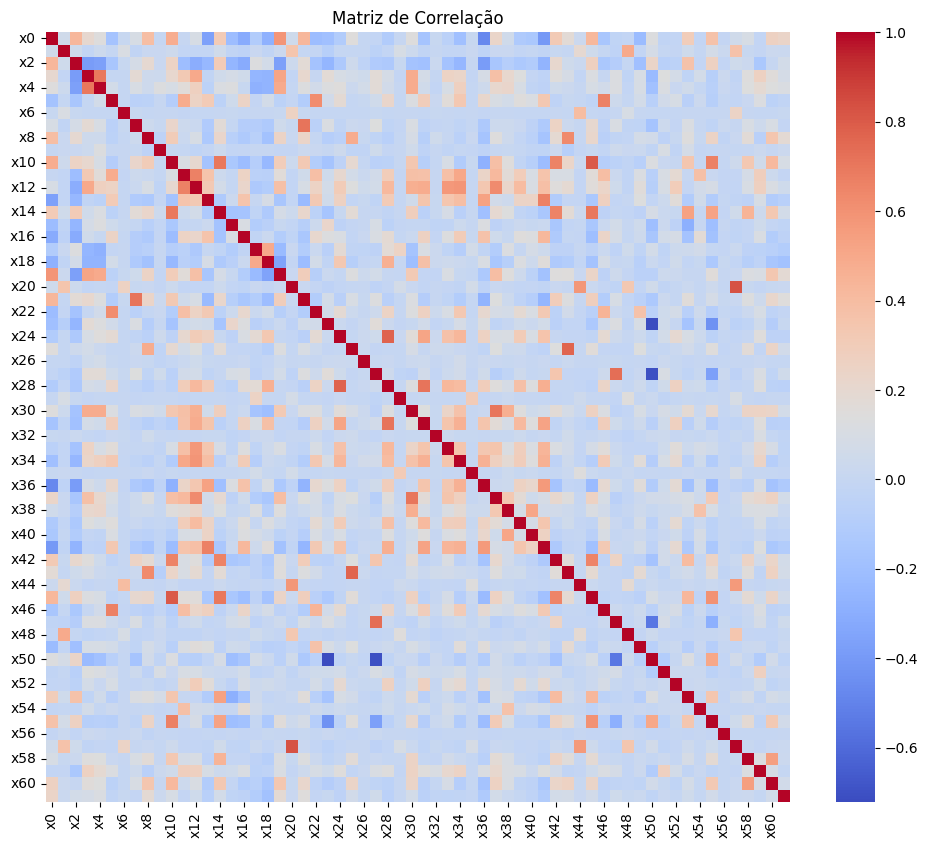

In [10]:
amostra = criar_amostra(df)

print("\nTamanho da amostra:", len(amostra))
print("Distribuição das classes na amostra:")
print(amostra['y'].value_counts(normalize=True))

corr_matrix = amostra.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()
plt.close()

In [11]:
estrategias = ['media', 'mediana', 'moda', 'constante']
dfs_tratados = {estrategia: tratar_nulos(amostra, estrategia) for estrategia in estrategias}
dfs_tratados.update({"analise de colunas": amostra_tratada})

for estrategia, df_tratado in dfs_tratados.items():
    print(f"\nEstatísticas após tratamento com {estrategia}:")
    print(df_tratado.describe())


Estatísticas após tratamento com media:
                 x0            x1            x2            x3            x4  \
count  15204.000000  1.520400e+04  15204.000000  15204.000000  15204.000000   
mean       0.653355  1.134751e-03      0.193970      0.066288      0.164432   
std        0.251848  1.057811e-02      0.193237      0.052626      0.121167   
min        0.000000  0.000000e+00      0.000000      0.000000      0.000000   
25%        0.500000  2.428434e-07      0.040934      0.046619      0.071948   
50%        0.700000  5.103086e-07      0.119917      0.066288      0.139535   
75%        0.833333  1.109844e-06      0.295584      0.066288      0.227471   
max        1.000000  7.197662e-01      0.970803      1.000000      0.965116   

                 x5            x6            x7            x8            x9  \
count  15204.000000  1.520400e+04  15204.000000  15204.000000  15204.000000   
mean       0.008042  2.247294e-04      0.724730      0.579601      0.327637   
std       

In [12]:
dados_preparados = {}
for estrategia, df_tratado in dfs_tratados.items():
    dados_preparados[estrategia] = preparar_dados(df_tratado, aplicar_pca=False)
    dados_preparados[f"{estrategia}_pca"] = preparar_dados(df_tratado, aplicar_pca=True)

for nome, dados in dados_preparados.items():
    X_train, X_test, y_train, y_test = dados
    print(f"\nEstatísticas para {nome}:")
    print(f"Forma de X_train: {X_train.shape}")
    print(f"Forma de X_test: {X_test.shape}")
    print(f"Distribuição de classes em y_train: {np.bincount(y_train)}")
    print(f"Distribuição de classes em y_test: {np.bincount(y_test)}")

Número de componentes PCA: 46
Número de componentes PCA: 46
Número de componentes PCA: 46
Número de componentes PCA: 46
Número de componentes PCA: 46

Estatísticas para media:
Forma de X_train: (20828, 61)
Forma de X_test: (3041, 61)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para media_pca:
Forma de X_train: (20828, 46)
Forma de X_test: (3041, 46)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para mediana:
Forma de X_train: (20828, 61)
Forma de X_test: (3041, 61)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para mediana_pca:
Forma de X_train: (20828, 46)
Forma de X_test: (3041, 46)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para moda:
Forma de X_train: (20828, 61)
Forma de X_test: (3041, 61)
Distribuição de classes em y_tr


Treinando modelos com estratégia: media

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 263.40 segundos
Avaliação do Random Forest (Estratégia de preparação: media):
Acurácia: 0.8556
Precisão: 0.8912
Recall: 0.9470
F1-Score: 0.9183
AUC-ROC: 0.7625
Precisão_Classe_0: 0.4964
Recall_Classe_0: 0.3112
F1-Score_Classe_0: 0.3826
Precisão_Classe_1: 0.8912
Recall_Classe_1: 0.9470
F1-Score_Classe_1: 0.9183


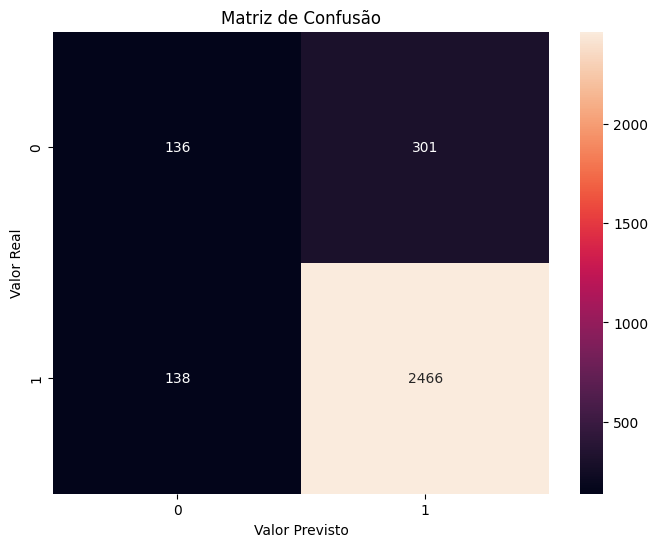


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 28.30 segundos
Avaliação do XGBoost (Estratégia de preparação: media):
Acurácia: 0.8563
Precisão: 0.8902
Recall: 0.9493
F1-Score: 0.9188
AUC-ROC: 0.7182
Precisão_Classe_0: 0.5000
Recall_Classe_0: 0.3021
F1-Score_Classe_0: 0.3766
Precisão_Classe_1: 0.8902
Recall_Classe_1: 0.9493
F1-Score_Classe_1: 0.9188


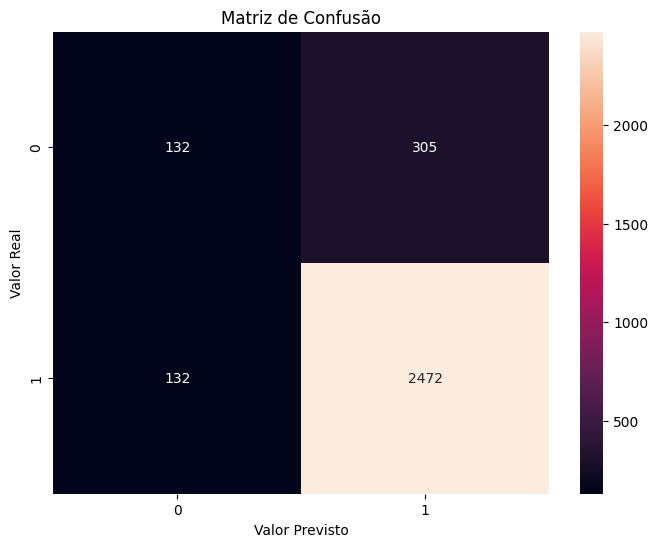


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15550
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Tempo de treinamento: 41.64 segundos
Avaliação do LightGBM (Estratégia de preparação: media):
Acurácia: 0.8648
Precisão: 0.8870
Recall: 0.9651
F1-Score: 0.9244
AUC-ROC: 0.7587
Precisão_Classe_0: 0.5625
Recall_Classe_0: 0.2677
F1-Score_Classe_0: 0.3628
Precisão_Classe_1: 0.8870
Recall_Classe_1: 0.9651
F1-Score_Classe_1: 0.9244


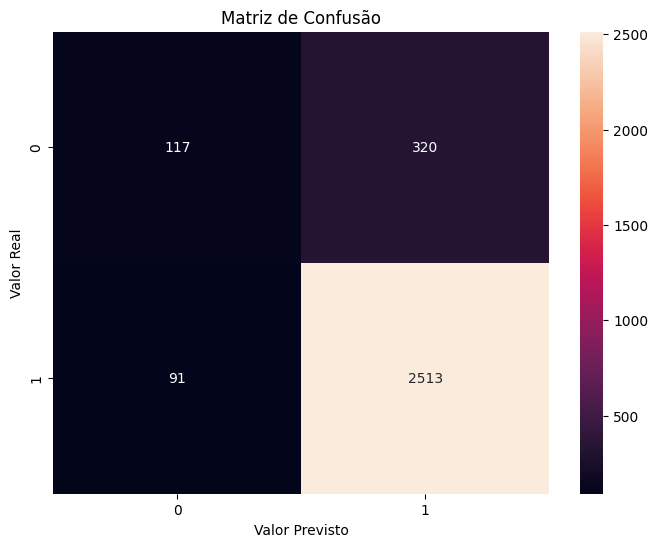


Treinando modelos com estratégia: media_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 280.43 segundos
Avaliação do Random Forest (Estratégia de preparação: media_pca):
Acurácia: 0.8359
Precisão: 0.8879
Recall: 0.9251
F1-Score: 0.9062
AUC-ROC: 0.7325
Precisão_Classe_0: 0.4055
Recall_Classe_0: 0.3043
F1-Score_Classe_0: 0.3477
Precisão_Classe_1: 0.8879
Recall_Classe_1: 0.9251
F1-Score_Classe_1: 0.9062


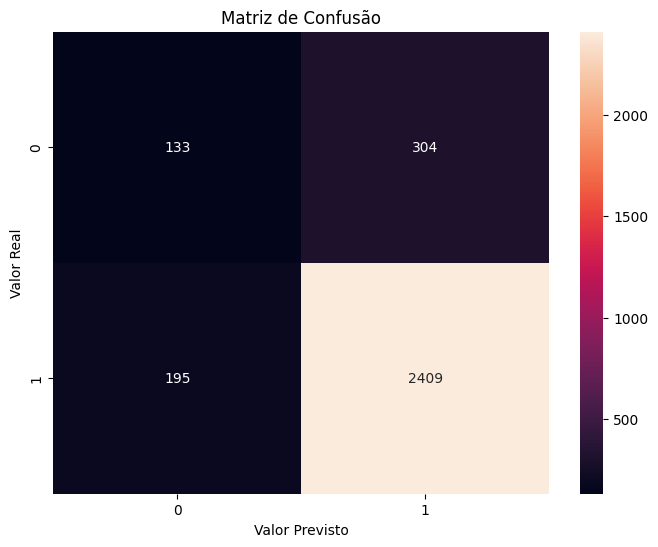


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 27.29 segundos
Avaliação do XGBoost (Estratégia de preparação: media_pca):
Acurácia: 0.7991
Precisão: 0.8906
Recall: 0.8725
F1-Score: 0.8815
AUC-ROC: 0.7005
Precisão_Classe_0: 0.3224
Recall_Classe_0: 0.3616
F1-Score_Classe_0: 0.3409
Precisão_Classe_1: 0.8906
Recall_Classe_1: 0.8725
F1-Score_Classe_1: 0.8815


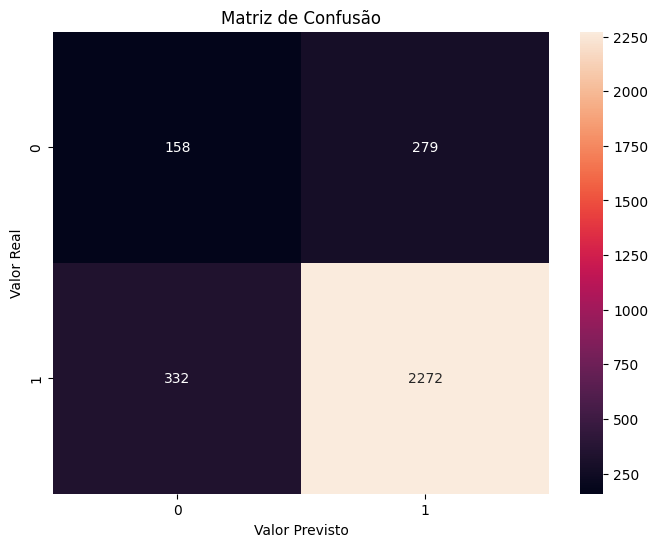


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

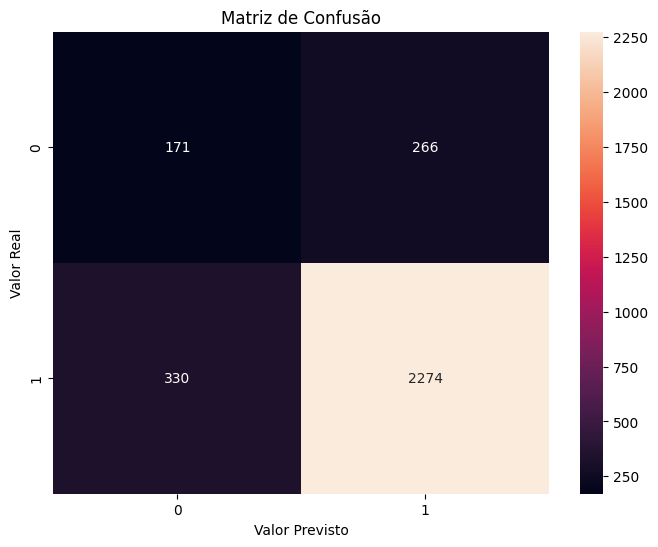


Treinando modelos com estratégia: mediana

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 256.19 segundos
Avaliação do Random Forest (Estratégia de preparação: mediana):
Acurácia: 0.8517
Precisão: 0.8939
Recall: 0.9382
F1-Score: 0.9155
AUC-ROC: 0.7644
Precisão_Classe_0: 0.4773
Recall_Classe_0: 0.3364
F1-Score_Classe_0: 0.3946
Precisão_Classe_1: 0.8939
Recall_Classe_1: 0.9382
F1-Score_Classe_1: 0.9155


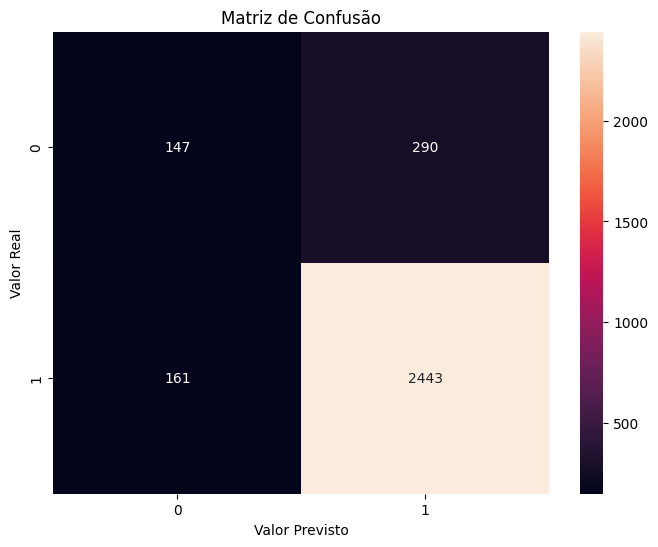


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 26.85 segundos
Avaliação do XGBoost (Estratégia de preparação: mediana):
Acurácia: 0.8550
Precisão: 0.8858
Recall: 0.9535
F1-Score: 0.9184
AUC-ROC: 0.7241
Precisão_Classe_0: 0.4916
Recall_Classe_0: 0.2677
F1-Score_Classe_0: 0.3467
Precisão_Classe_1: 0.8858
Recall_Classe_1: 0.9535
F1-Score_Classe_1: 0.9184


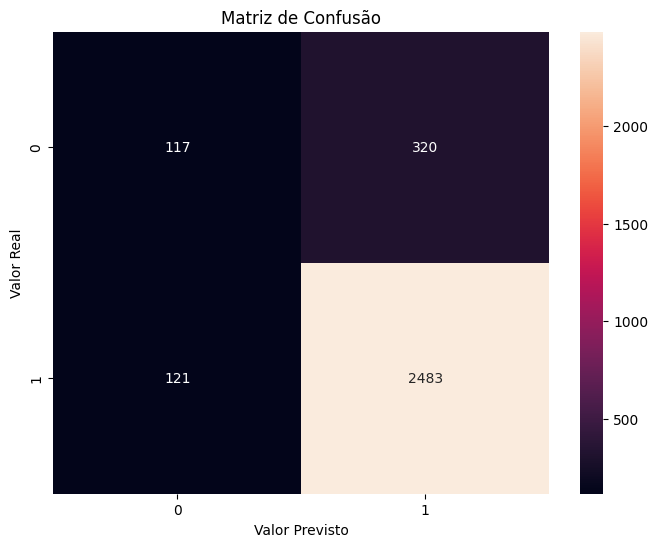


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15550
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Tempo de treinamento: 39.54 segundos
Avaliação do LightGBM (Estratégia de preparação: mediana):
Acurácia: 0.8662
Precisão: 0.8875
Recall: 0.9662
F1-Score: 0.9252
AUC-ROC: 0.7569
Precisão_Classe_0: 0.5728
Recall_Classe_0: 0.2700
F1-Score_Classe_0: 0.3670
Precisão_Classe_1: 0.8875
Recall_Classe_1: 0.9662
F1-Score_Classe_1: 0.9252


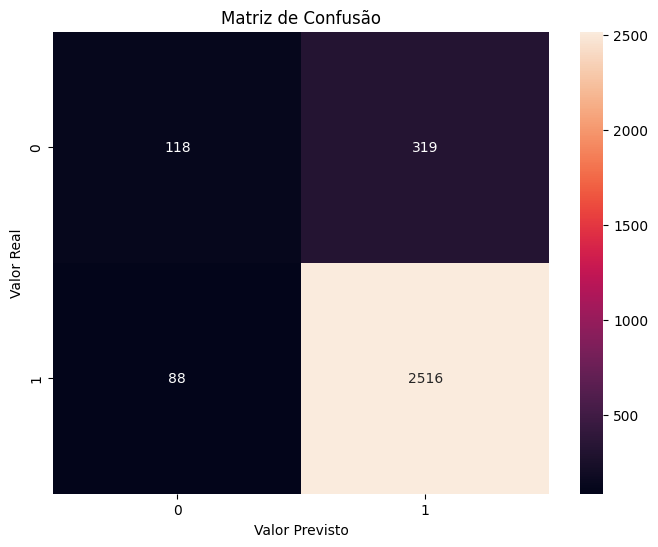


Treinando modelos com estratégia: mediana_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 282.50 segundos
Avaliação do Random Forest (Estratégia de preparação: mediana_pca):
Acurácia: 0.8392
Precisão: 0.8898
Recall: 0.9270
F1-Score: 0.9080
AUC-ROC: 0.7246
Precisão_Classe_0: 0.4207
Recall_Classe_0: 0.3158
F1-Score_Classe_0: 0.3608
Precisão_Classe_1: 0.8898
Recall_Classe_1: 0.9270
F1-Score_Classe_1: 0.9080


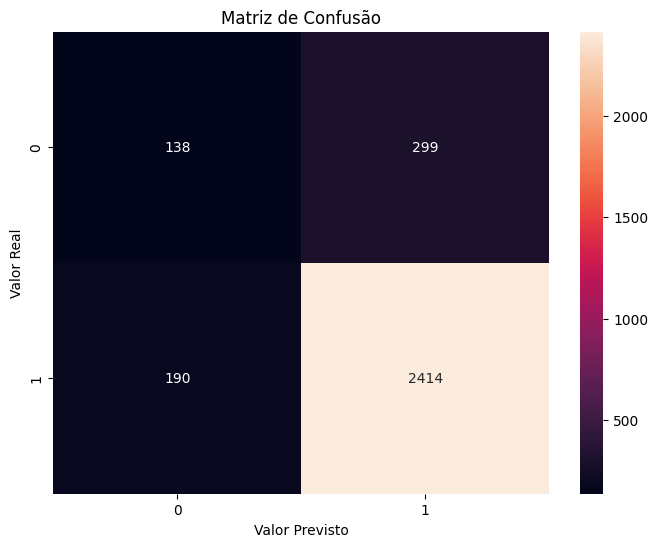


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 26.65 segundos
Avaliação do XGBoost (Estratégia de preparação: mediana_pca):
Acurácia: 0.7984
Precisão: 0.8915
Recall: 0.8706
F1-Score: 0.8809
AUC-ROC: 0.6941
Precisão_Classe_0: 0.3233
Recall_Classe_0: 0.3684
F1-Score_Classe_0: 0.3444
Precisão_Classe_1: 0.8915
Recall_Classe_1: 0.8706
F1-Score_Classe_1: 0.8809


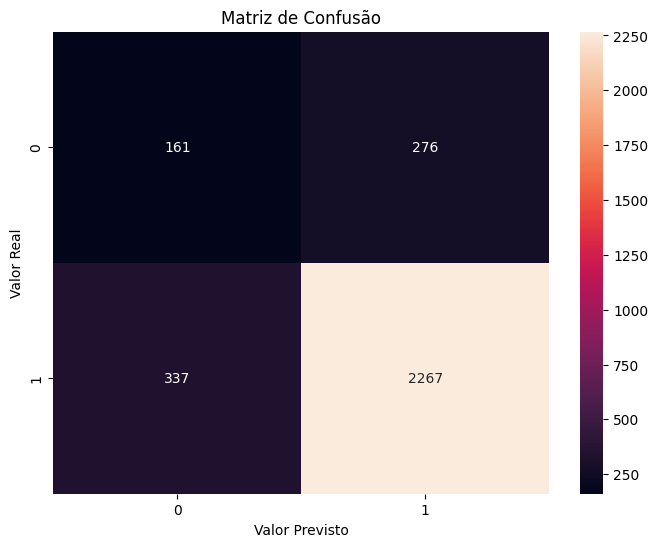


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

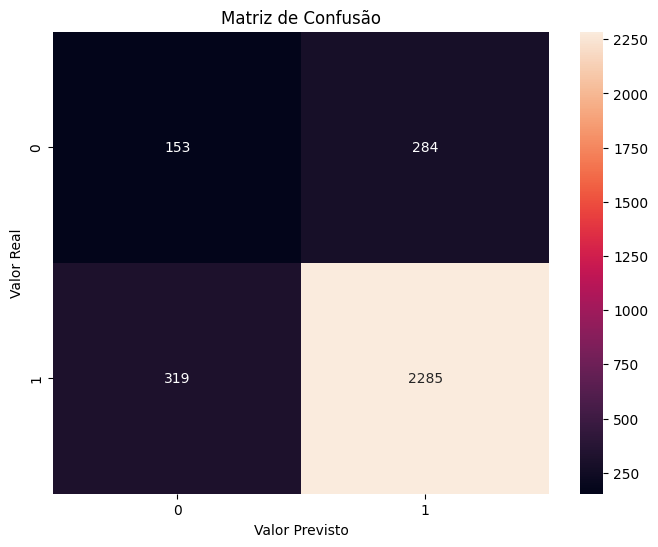


Treinando modelos com estratégia: moda

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 244.95 segundos
Avaliação do Random Forest (Estratégia de preparação: moda):
Acurácia: 0.8533
Precisão: 0.8976
Recall: 0.9355
F1-Score: 0.9161
AUC-ROC: 0.7697
Precisão_Classe_0: 0.4862
Recall_Classe_0: 0.3638
F1-Score_Classe_0: 0.4162
Precisão_Classe_1: 0.8976
Recall_Classe_1: 0.9355
F1-Score_Classe_1: 0.9161


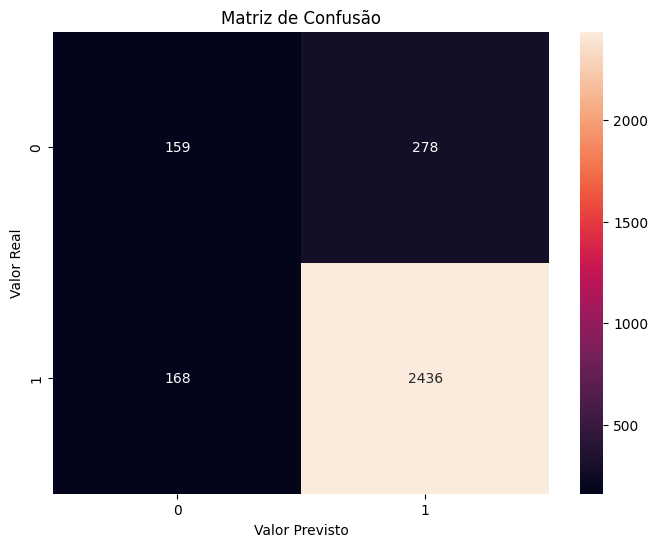


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 33.25 segundos
Avaliação do XGBoost (Estratégia de preparação: moda):
Acurácia: 0.8579
Precisão: 0.8918
Recall: 0.9493
F1-Score: 0.9196
AUC-ROC: 0.7469
Precisão_Classe_0: 0.5093
Recall_Classe_0: 0.3135
F1-Score_Classe_0: 0.3881
Precisão_Classe_1: 0.8918
Recall_Classe_1: 0.9493
F1-Score_Classe_1: 0.9196


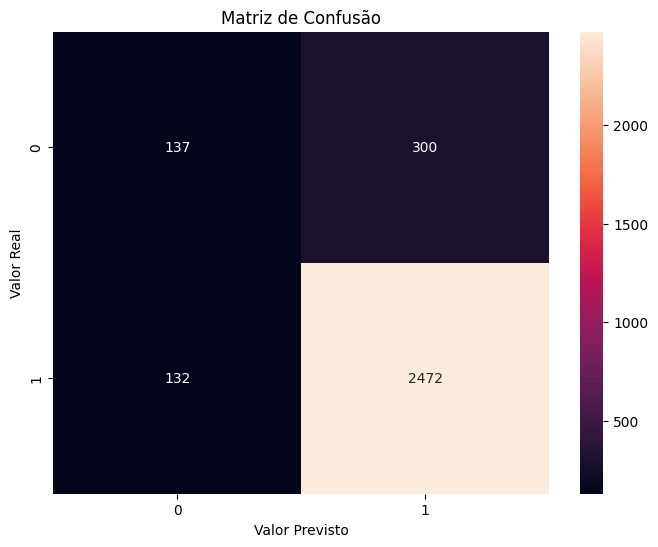


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15551
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Tempo de treinamento: 32.86 segundos
Avaliação do LightGBM (Estratégia de preparação: moda):
Acurácia: 0.8658
Precisão: 0.8874
Recall: 0.9658
F1-Score: 0.9250
AUC-ROC: 0.7670
Precisão_Classe_0: 0.5700
Recall_Classe_0: 0.2700
F1-Score_Classe_0: 0.3665
Precisão_Classe_1: 0.8874
Recall_Classe_1: 0.9658
F1-Score_Classe_1: 0.9250


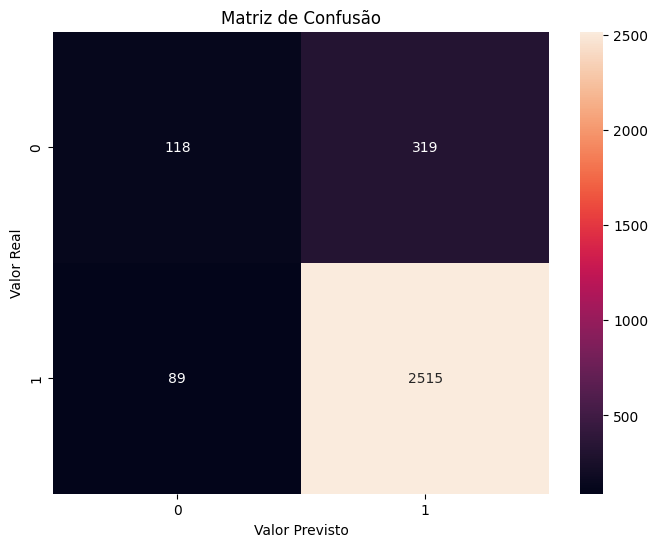


Treinando modelos com estratégia: moda_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 307.24 segundos
Avaliação do Random Forest (Estratégia de preparação: moda_pca):
Acurácia: 0.8425
Precisão: 0.8902
Recall: 0.9309
F1-Score: 0.9101
AUC-ROC: 0.7362
Precisão_Classe_0: 0.4340
Recall_Classe_0: 0.3158
F1-Score_Classe_0: 0.3656
Precisão_Classe_1: 0.8902
Recall_Classe_1: 0.9309
F1-Score_Classe_1: 0.9101


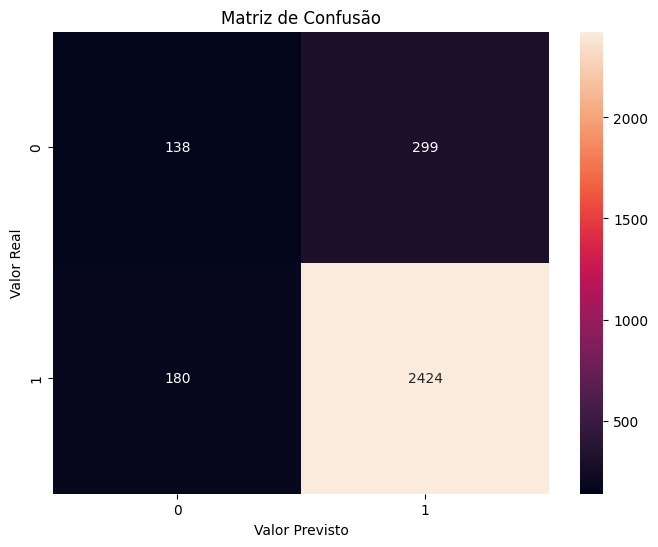


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 22.24 segundos
Avaliação do XGBoost (Estratégia de preparação: moda_pca):
Acurácia: 0.8001
Precisão: 0.8905
Recall: 0.8740
F1-Score: 0.8822
AUC-ROC: 0.7037
Precisão_Classe_0: 0.3237
Recall_Classe_0: 0.3593
F1-Score_Classe_0: 0.3406
Precisão_Classe_1: 0.8905
Recall_Classe_1: 0.8740
F1-Score_Classe_1: 0.8822


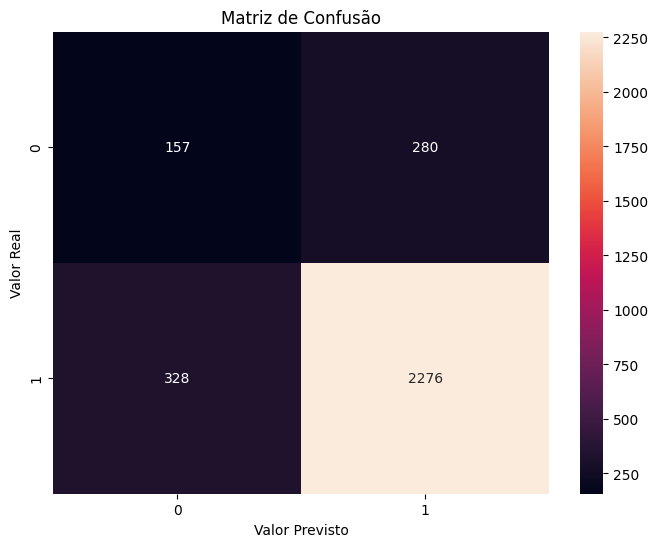


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

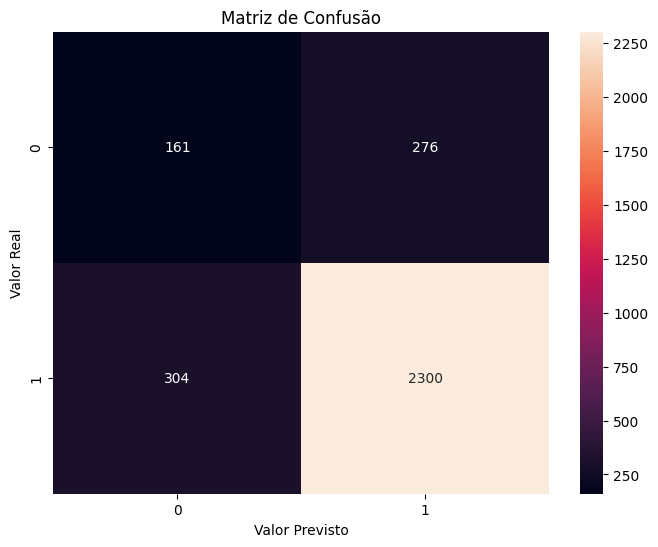


Treinando modelos com estratégia: constante

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 245.06 segundos
Avaliação do Random Forest (Estratégia de preparação: constante):
Acurácia: 0.8537
Precisão: 0.9009
Recall: 0.9316
F1-Score: 0.9160
AUC-ROC: 0.7783
Precisão_Classe_0: 0.4885
Recall_Classe_0: 0.3890
F1-Score_Classe_0: 0.4331
Precisão_Classe_1: 0.9009
Recall_Classe_1: 0.9316
F1-Score_Classe_1: 0.9160


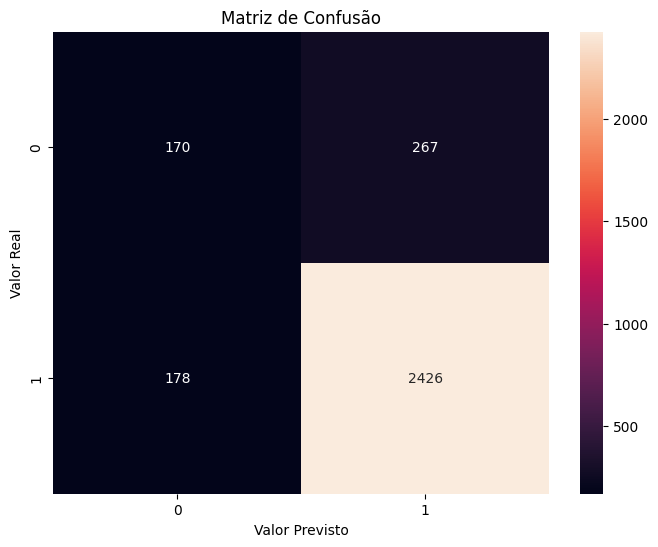


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 30.38 segundos
Avaliação do XGBoost (Estratégia de preparação: constante):
Acurácia: 0.8616
Precisão: 0.8931
Recall: 0.9524
F1-Score: 0.9218
AUC-ROC: 0.7543
Precisão_Classe_0: 0.5303
Recall_Classe_0: 0.3204
F1-Score_Classe_0: 0.3994
Precisão_Classe_1: 0.8931
Recall_Classe_1: 0.9524
F1-Score_Classe_1: 0.9218


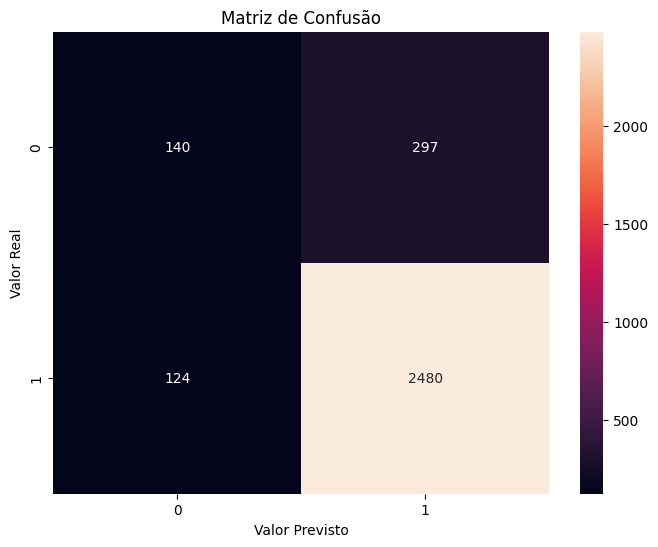


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15551
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

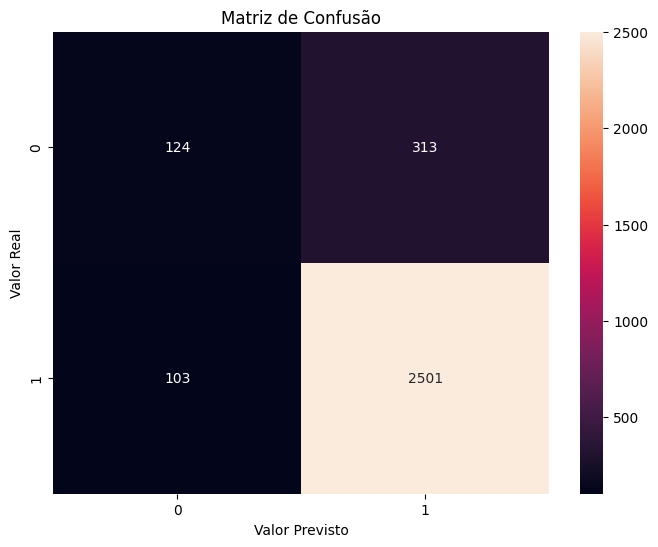


Treinando modelos com estratégia: constante_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 274.96 segundos
Avaliação do Random Forest (Estratégia de preparação: constante_pca):
Acurácia: 0.8428
Precisão: 0.8937
Recall: 0.9267
F1-Score: 0.9099
AUC-ROC: 0.7436
Precisão_Classe_0: 0.4399
Recall_Classe_0: 0.3432
F1-Score_Classe_0: 0.3856
Precisão_Classe_1: 0.8937
Recall_Classe_1: 0.9267
F1-Score_Classe_1: 0.9099


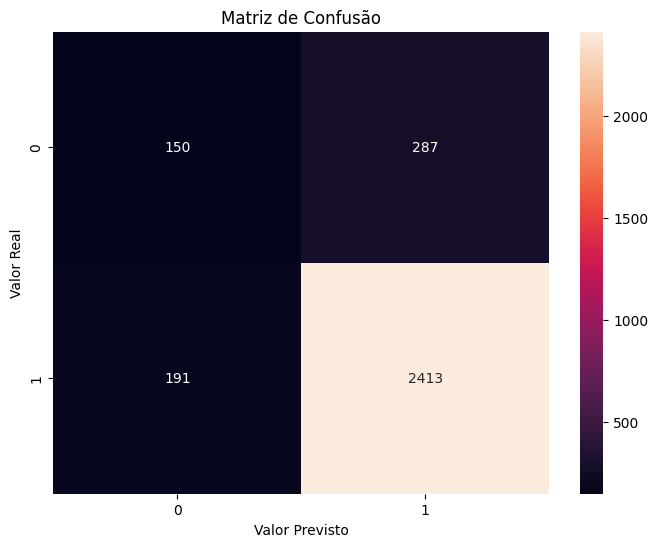


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 34.41 segundos
Avaliação do XGBoost (Estratégia de preparação: constante_pca):
Acurácia: 0.7958
Precisão: 0.8927
Recall: 0.8656
F1-Score: 0.8789
AUC-ROC: 0.6925
Precisão_Classe_0: 0.3217
Recall_Classe_0: 0.3799
F1-Score_Classe_0: 0.3484
Precisão_Classe_1: 0.8927
Recall_Classe_1: 0.8656
F1-Score_Classe_1: 0.8789


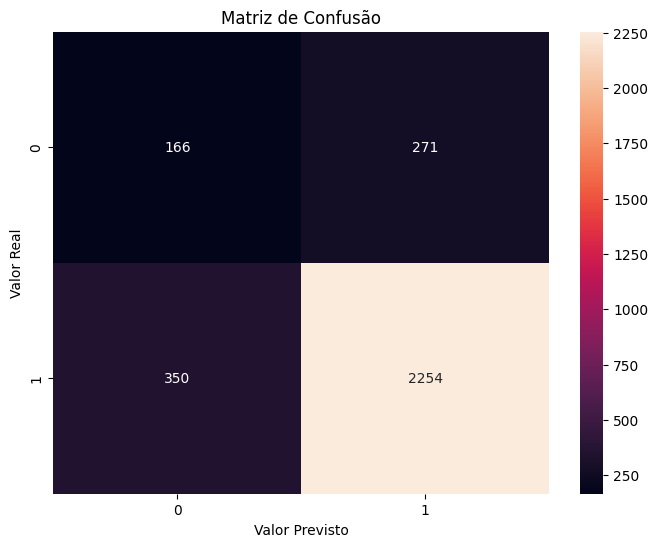


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

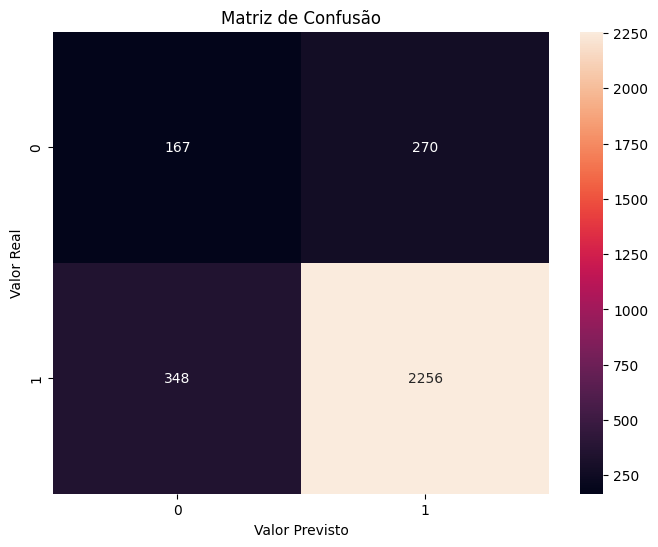


Treinando modelos com estratégia: analise de colunas

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 255.42 segundos
Avaliação do Random Forest (Estratégia de preparação: analise de colunas):
Acurácia: 0.8428
Precisão: 0.8843
Recall: 0.9393
F1-Score: 0.9110
AUC-ROC: 0.7339
Precisão_Classe_0: 0.4234
Recall_Classe_0: 0.2661
F1-Score_Classe_0: 0.3268
Precisão_Classe_1: 0.8843
Recall_Classe_1: 0.9393
F1-Score_Classe_1: 0.9110


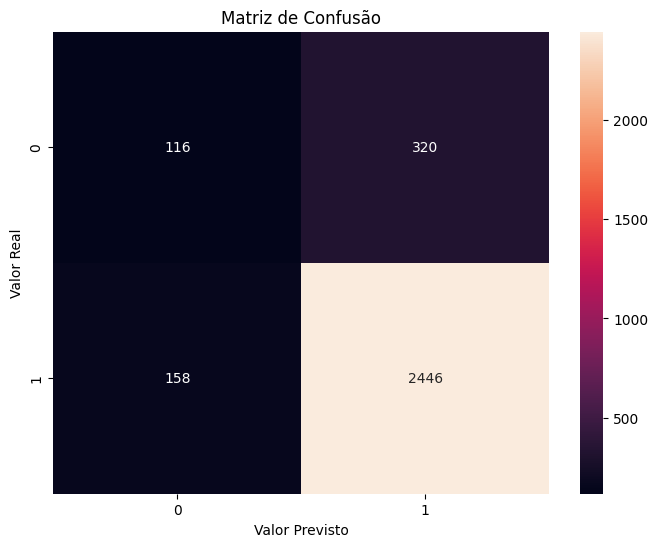


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 26.59 segundos
Avaliação do XGBoost (Estratégia de preparação: analise de colunas):
Acurácia: 0.8441
Precisão: 0.8771
Recall: 0.9512
F1-Score: 0.9127
AUC-ROC: 0.7194
Precisão_Classe_0: 0.4120
Recall_Classe_0: 0.2041
F1-Score_Classe_0: 0.2730
Precisão_Classe_1: 0.8771
Recall_Classe_1: 0.9512
F1-Score_Classe_1: 0.9127


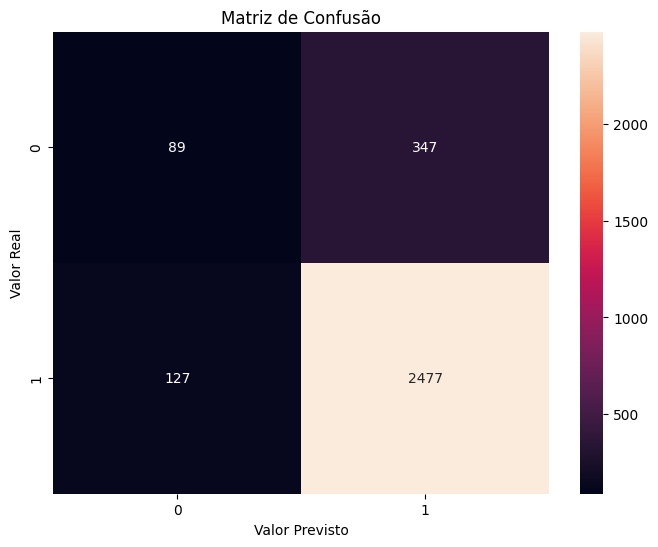


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10413, number of negative: 10413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15553
[LightGBM] [Info] Number of data points in the train set: 20826, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Tempo de treinamento: 34.35 segundos
Avaliação do LightGBM (Estratégia de preparação: analise de colunas):
Acurácia: 0.8546
Precisão: 0.8788
Recall: 0.9631
F1-Score: 0.9190
AUC-ROC: 0.7304
Precisão_Classe_0: 0.4839
Recall_Classe_0: 0.2064
F1-Score_Classe_0: 0.2894
Precisão_Classe_1: 0.8788
Recall_Classe_1: 0.9631
F1-Score_Classe_1: 0.9190


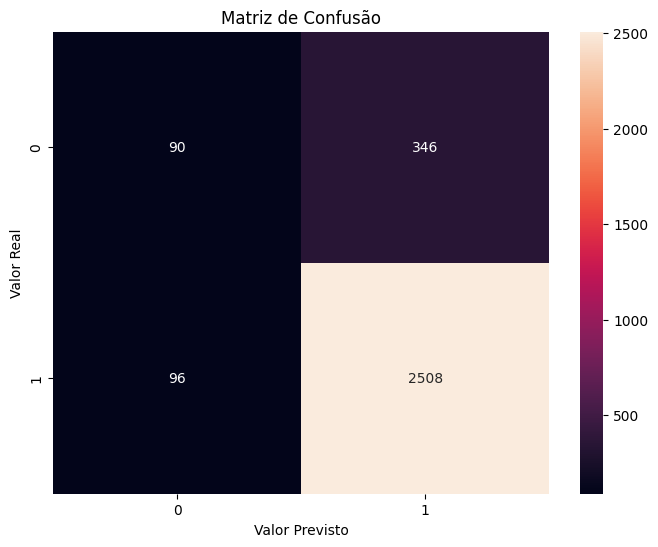


Treinando modelos com estratégia: analise de colunas_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 289.09 segundos
Avaliação do Random Forest (Estratégia de preparação: analise de colunas_pca):
Acurácia: 0.8280
Precisão: 0.8810
Recall: 0.9240
F1-Score: 0.9020
AUC-ROC: 0.6941
Precisão_Classe_0: 0.3592
Recall_Classe_0: 0.2546
F1-Score_Classe_0: 0.2980
Precisão_Classe_1: 0.8810
Recall_Classe_1: 0.9240
F1-Score_Classe_1: 0.9020


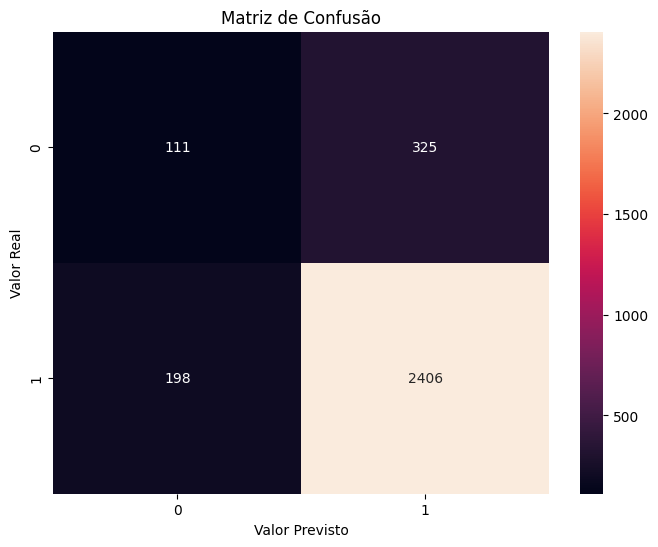


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 27.43 segundos
Avaliação do XGBoost (Estratégia de preparação: analise de colunas_pca):
Acurácia: 0.7980
Precisão: 0.8827
Recall: 0.8813
F1-Score: 0.8820
AUC-ROC: 0.6615
Precisão_Classe_0: 0.2977
Recall_Classe_0: 0.3005
F1-Score_Classe_0: 0.2991
Precisão_Classe_1: 0.8827
Recall_Classe_1: 0.8813
F1-Score_Classe_1: 0.8820


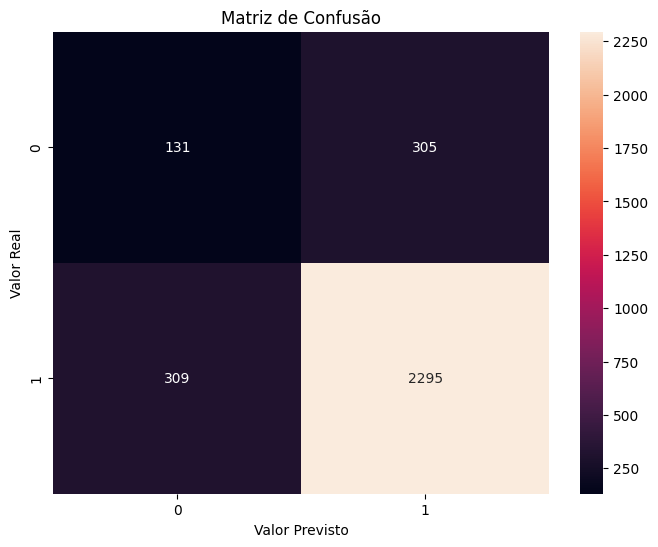


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10413, number of negative: 10413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20826, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

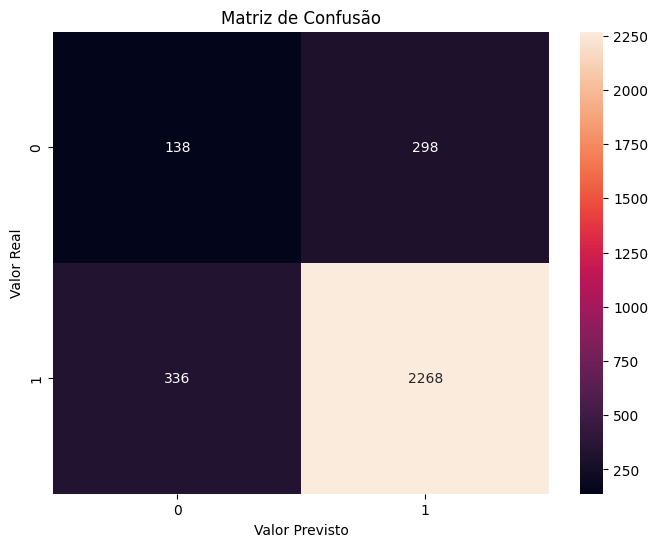


Todos os resultados foram salvos em 'resultados_modelos.parquet'


In [13]:
todos_resultados = []
modelos_treinados = {}

for estrategia, (X_train, X_test, y_train, y_test) in dados_preparados.items():
    print(f"\nTreinando modelos com estratégia: {estrategia}")
    resultados, modelos = treinar_e_avaliar(X_train, X_test, y_train, y_test, estrategia)
    todos_resultados.extend(resultados)
    modelos_treinados[estrategia] = modelos

df_todos_resultados = pd.DataFrame(todos_resultados)
df_todos_resultados.to_parquet('resultados_modelos.parquet')

print("\nTodos os resultados foram salvos em 'resultados_modelos.parquet'")

[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15550
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15550
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Melhor modelo: LightGBM com estratégia mediana
Pontuação média: 0.7755
Acurácia: 0.8662
Precisão Classe 0: 0.5728
Preci

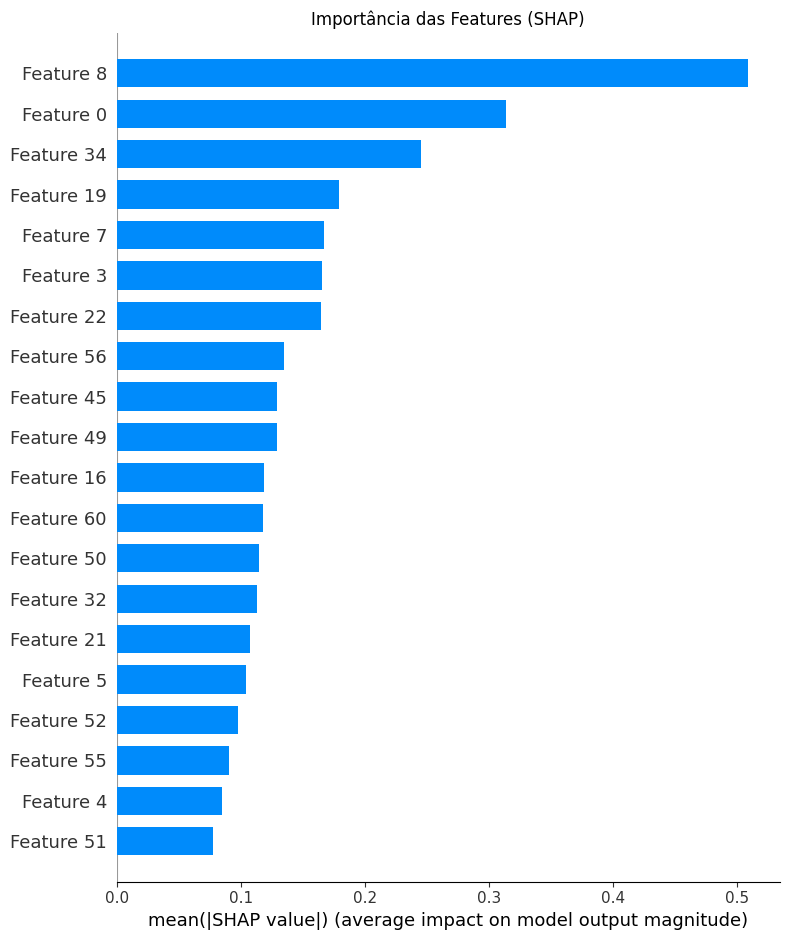

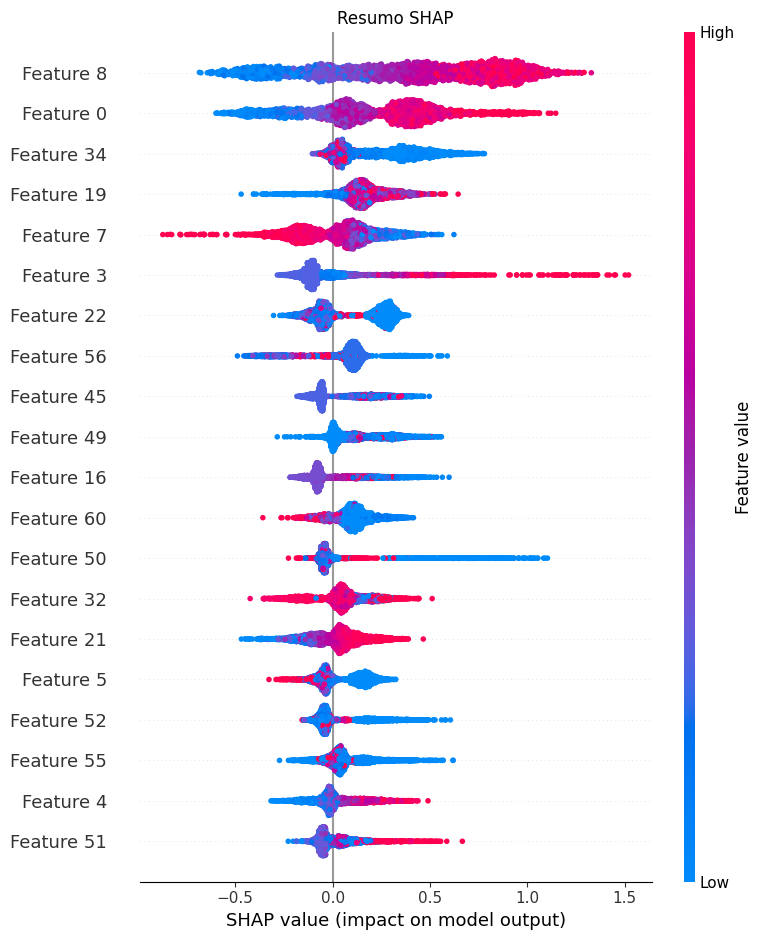

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [69]:
melhor_estrategia, melhor_nome, melhor_modelo, melhor_pontuacao, melhor_acuracia, melhor_precisao_0, melhor_precisao_1 = selecionar_melhor_modelo(todos_resultados, dados_preparados)

print(f"\nMelhor modelo: {melhor_nome} com estratégia {melhor_estrategia}")
print(f"Pontuação média: {melhor_pontuacao:.4f}")
print(f"Acurácia: {melhor_acuracia:.4f}")
print(f"Precisão Classe 0: {melhor_precisao_0:.4f}")
print(f"Precisão Classe 1: {melhor_precisao_1:.4f}")

# Continuar com a análise SHAP
X_test = dados_preparados[melhor_estrategia][1]
explainer = shap.TreeExplainer(melhor_modelo)
shap_values = explainer.shap_values(X_test)

# Plotar o gráfico de barras SHAP original
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importância das Features (SHAP)")
plt.tight_layout()
plt.show()

# Plotar o gráfico de resumo SHAP original
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Resumo SHAP")
plt.tight_layout()
plt.show()

# Novo gráfico para features menos relevantes
# Calcular a importância média absoluta de cada feature
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_test.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=True)  # Ordenar do menos importante para o mais importante

# Novo gráfico para features menos relevantes
# Calcular a importância média absoluta de cada feature
feature_importance = np.abs(shap_values).mean(0)

# Obter os nomes das features do DataFrame original antes da conversão para numpy array
feature_names = dados_preparados[melhor_estrategia][1].columns if hasattr(dados_preparados[melhor_estrategia][1], 'columns') else [f'feature_{i}' for i in range(len(feature_importance))]

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=True)

# Selecionar as 10 features menos importantes
menos_importantes = importance_df.head(10)

# Criar gráfico de barras horizontais para as features menos relevantes
plt.figure(figsize=(12, 8))
plt.barh(menos_importantes['feature'], menos_importantes['importance'])
plt.title('10 Features Menos Relevantes (SHAP)')
plt.xlabel('Importância Média Absoluta SHAP')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [65]:
def treinar_e_prever_modelo_final2(df, test, melhor_modelo):
    print("\nTreinando modelo final com todos os dados...")
    df_final = df.reset_index(drop=True)
    X_final = df_final.drop('y', axis=1)
    y_final = df_final['y']

    scaler_final = StandardScaler()
    X_final_scaled = scaler_final.fit_transform(X_final)

    smote_final = SMOTE(random_state=42)
    X_final_balanced, y_final_balanced = smote_final.fit_resample(X_final_scaled, y_final)

    modelo_final = melhor_modelo.__class__(random_state=42)
    modelo_final.fit(X_final_balanced, y_final_balanced)

    # Corrigindo aqui - pegando apenas o DataFrame retornado
    test_tratado, _ = analisar_e_tratar_nulos(test)
    X_test_final = test_tratado.drop('y', axis=1) if 'y' in test_tratado.columns else test_tratado

    colunas_faltantes = set(X_final.columns) - set(X_test_final.columns)
    for coluna in colunas_faltantes:
        X_test_final[coluna] = 0

    X_test_final = X_test_final[X_final.columns]

    X_test_final_scaled = scaler_final.transform(X_test_final)
    y_pred_final = modelo_final.predict(X_test_final_scaled)

    predicoes = pd.DataFrame({'y_pred': y_pred_final})

    if 'id' not in test.columns:
        print("Aviso: A coluna 'id' não está presente no DataFrame de teste.")
        print("Salvando as previsões com o índice como identificador...")
        predicoes.to_csv('predicoes_finais.csv', index=True)
        print("Previsões finais salvas em 'predicoes_finais.csv' com o índice como identificador.")
    else:
        predicoes['id'] = test['id']
        predicoes[['id', 'y_pred']].to_csv('predicoes_finais.csv', index=False)
        print("Previsões finais salvas em 'predicoes_finais.csv'")

    return predicoes, modelo_final, y_pred_final, X_test_final_scaled  # Retornando também os dados escalados



Treinando modelo final com todos os dados...
[LightGBM] [Info] Number of positive: 130173, number of negative: 130173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15549
[LightGBM] [Info] Number of data points in the train set: 260346, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Coluna: x0
Shapiro p-valor: 4.744438020244903e-48
Anderson estatística: 124.27750451311294, valor crítico: 0.787
Coluna: x3
Shapiro p-valor: 1.756825506952263e-83
Anderson estatística: 580.230526115598, valor crítico: 0.787
Coluna: x6
Shapiro p-valor: 3.8118903282039036e-114
Anderson estatística: 3725.219421842583, valor crítico: 0.787
Coluna: x8
Shapiro p-valor: 8.543808459527449e-32
Anderson estatística: 33.39978537605748, valor crítico: 0.787
Coluna: x9
Shapiro p-valor: 8.787830551647042e-66
Anderson es

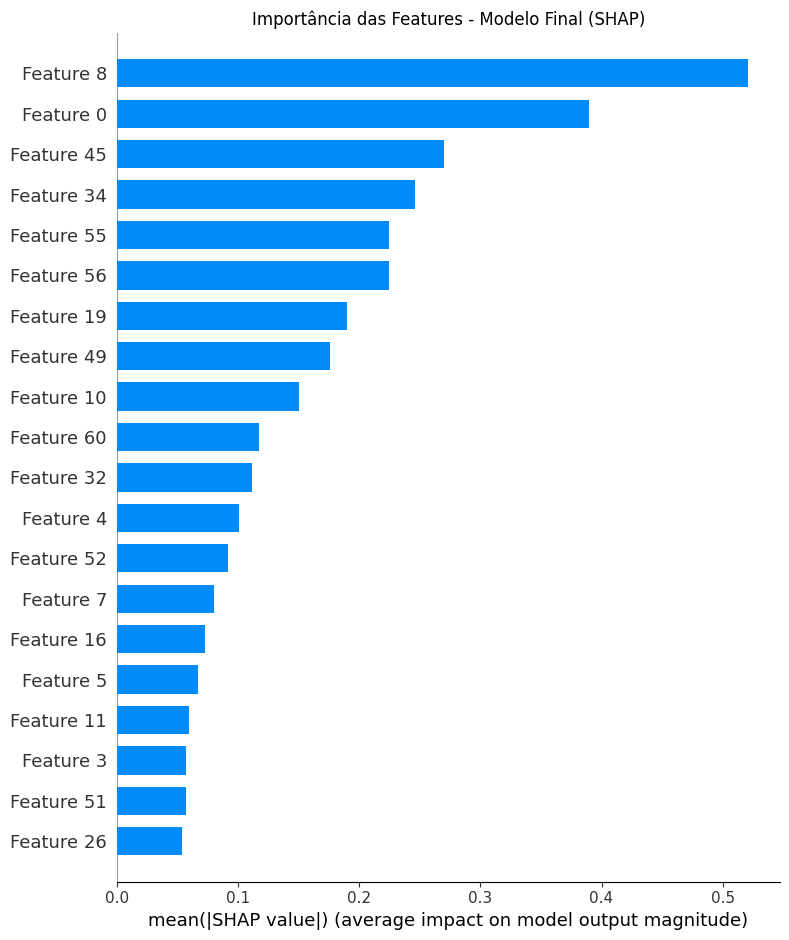

ValueError: Found input variables with inconsistent numbers of samples: [10746, 10745]

In [66]:
# Treinar modelo e obter previsões
predicoes, modelo_final, y_pred_final, X_test_scaled = treinar_e_prever_modelo_final2(df_limpo, test, melhor_modelo)
print("\nPrevisões finais geradas e modelo final treinado.")

# Análise SHAP usando os dados escalados
explainer = shap.TreeExplainer(modelo_final)
shap_values = explainer.shap_values(X_test_scaled)

# Gráfico de importância das features (SHAP)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title("Importância das Features - Modelo Final (SHAP)")
plt.tight_layout()
plt.show()

# Curva ROC
y_prob = modelo_final.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(test['y'], y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo Final')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Análise das features
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_test_scaled.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=True)

# 10 features menos importantes
menos_importantes = importance_df.head(10)
mais_importantes = importance_df.tail(10)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(menos_importantes['feature'], menos_importantes['importance'])
plt.title('10 Features Menos Relevantes - Modelo Final (SHAP)')
plt.xlabel('Importância Média Absoluta SHAP')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\n10 Features Mais Importantes:")
for idx, row in mais_importantes.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print("\n10 Features Menos Importantes:")
for idx, row in menos_importantes.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


Testando o modelo final com o conjunto de teste...
Acurácia: 0.7877
Precisão: 0.8458
Recall: 0.8892
F1-Score: 0.8670


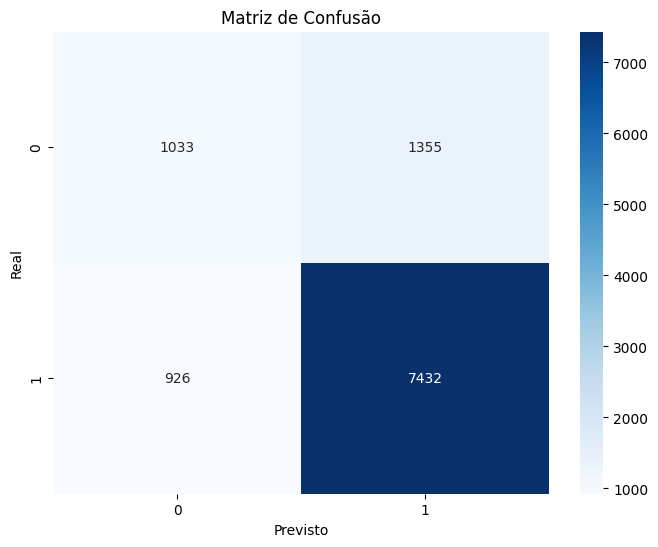


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.53      0.43      0.48      2388
           1       0.85      0.89      0.87      8358

    accuracy                           0.79     10746
   macro avg       0.69      0.66      0.67     10746
weighted avg       0.78      0.79      0.78     10746


Total de amostras: 10746
Acertos: 8465 (78.77%)
Erros: 2281 (21.23%)


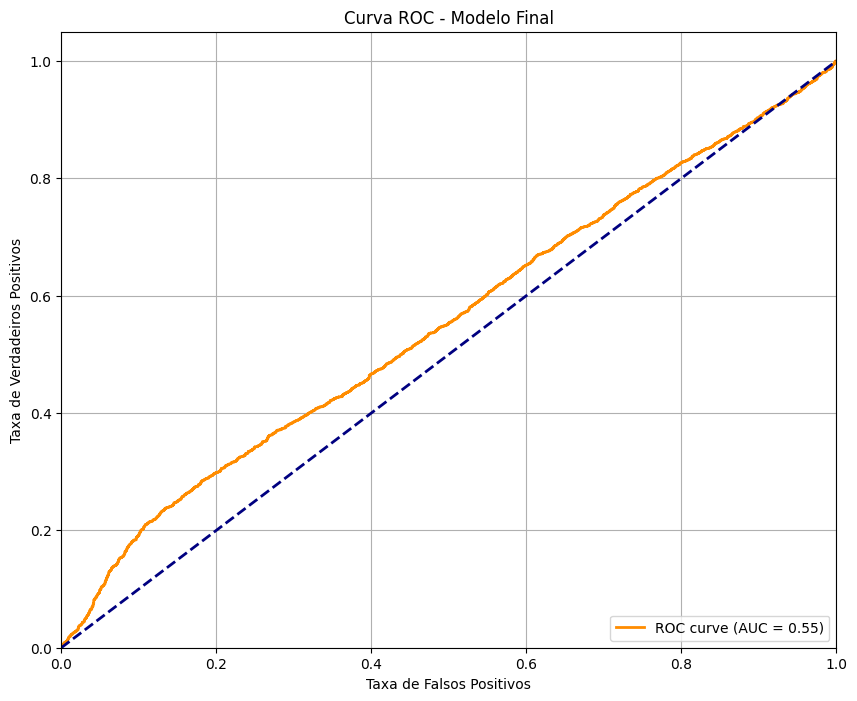

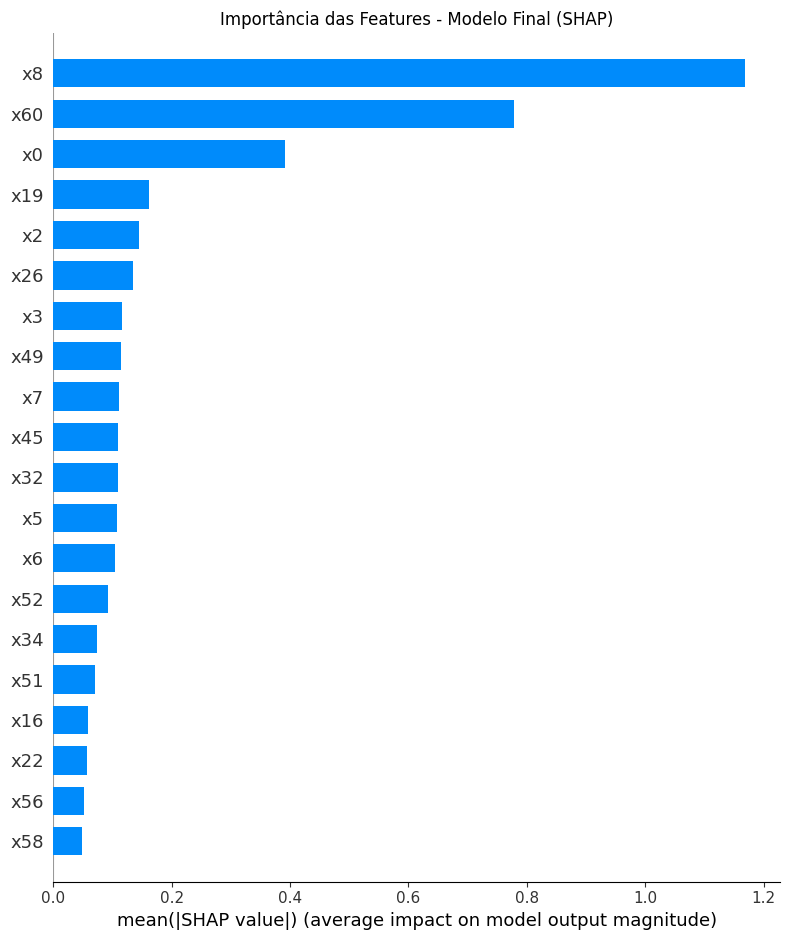

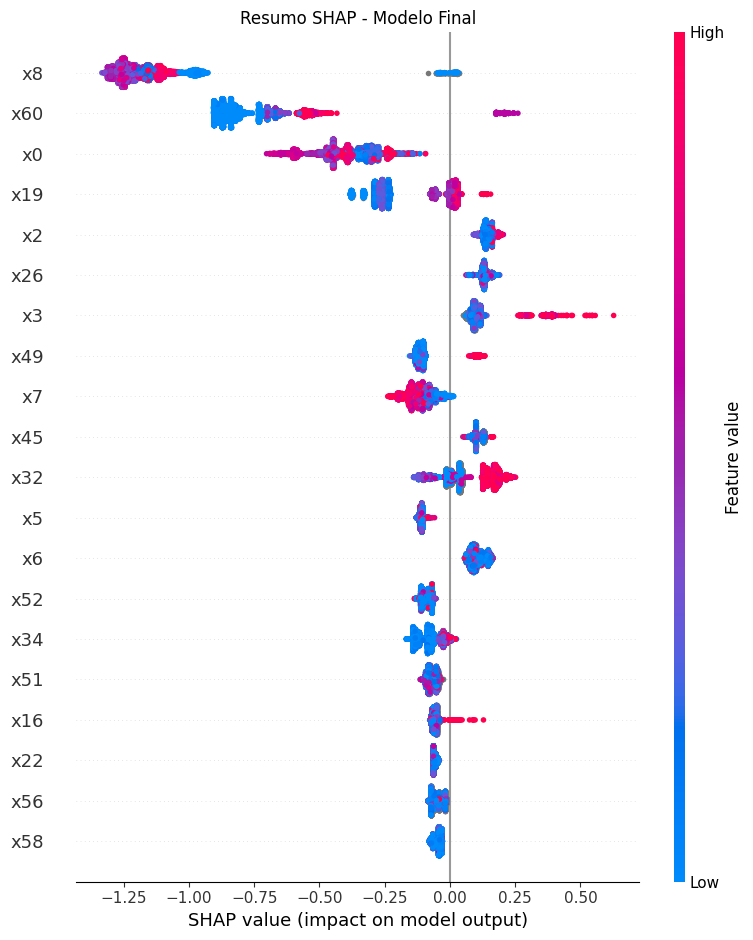

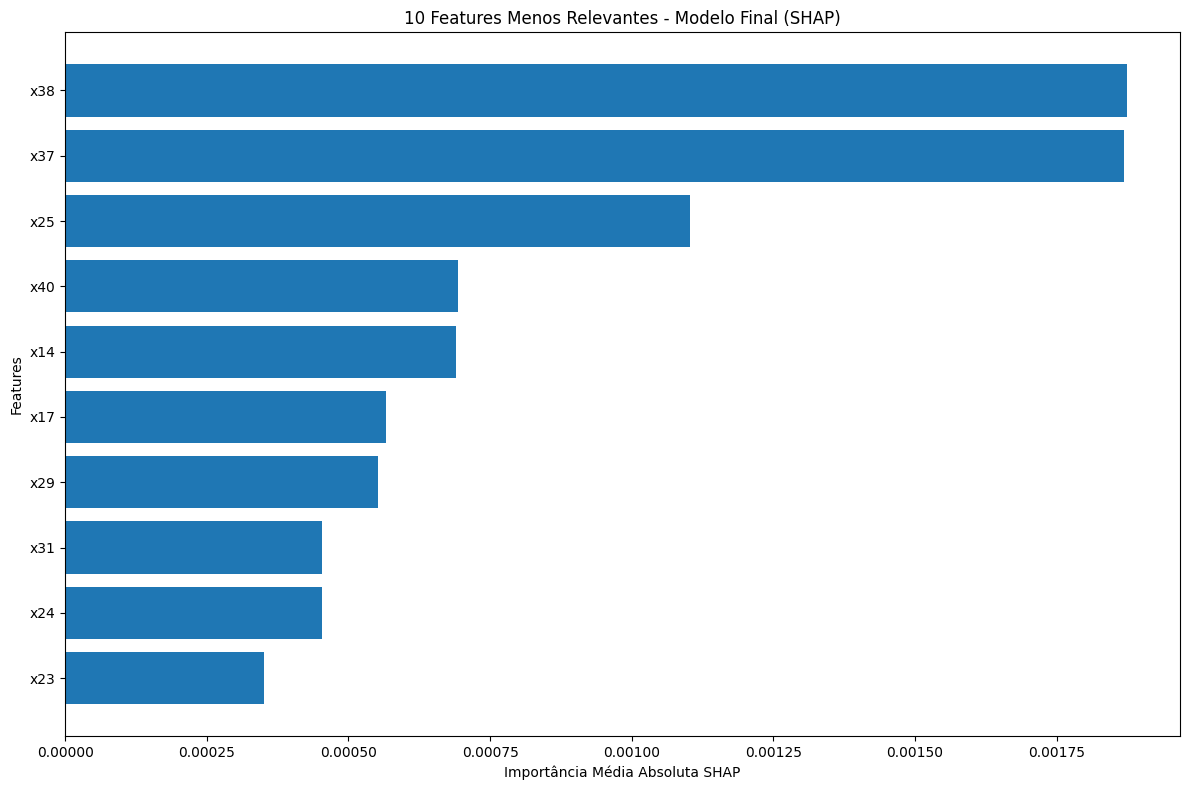


10 Features Mais Importantes:
x8: 1.1692
x60: 0.7780
x0: 0.3916
x19: 0.1611
x2: 0.1442
x26: 0.1347
x3: 0.1156
x49: 0.1138
x7: 0.1115
x45: 0.1097

10 Features Menos Importantes:
x23: 0.0004
x24: 0.0005
x31: 0.0005
x29: 0.0006
x17: 0.0006
x14: 0.0007
x40: 0.0007
x25: 0.0011
x37: 0.0019
x38: 0.0019


In [59]:
# Avaliação básica do modelo
avaliar_modelo_final(y_pred_final, test)